In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [26]:
books = pd.read_csv('content/Books.csv')
ratings = pd.read_csv('content/Ratings.csv')
users = pd.read_csv('content/Users.csv')

print("Dataset Shapes:")
print(f"Books: {books.shape}")
print(f"Users: {users.shape}")
print(f"Ratings: {ratings.shape}")

print("\n=== BOOKS DATASET ===")
print(books.head())
print(books.info())

print("\n=== USERS DATASET ===")
print(users.head())
print(users.info())

print("\n=== RATINGS DATASET ===")
print(ratings.head())
print(ratings.info())

C:\Users\enric\AppData\Local\Temp\ipykernel_23244\2199575811.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('content/Books.csv')


Dataset Shapes:
Books: (271360, 8)
Users: (278858, 3)
Ratings: (1149780, 3)

=== BOOKS DATASET ===
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         

In [27]:
# Clean ratings data - remove rating 0 (implicit feedback only)
print(f"Original ratings shape: {ratings.shape}")
print(f"Rating distribution:\n{ratings['Book-Rating'].value_counts().sort_index()}")

# Remove implicit ratings (rating = 0) and keep only explicit ratings (1-10)
ratings_explicit = ratings[ratings['Book-Rating'] != 0].copy()
print(f"Explicit ratings shape: {ratings_explicit.shape}")

min_book_ratings = 10
min_user_ratings = 5 

# Filter books
book_counts = ratings_explicit['ISBN'].value_counts()
popular_books = book_counts[book_counts >= min_book_ratings].index
ratings_filtered = ratings_explicit[ratings_explicit['ISBN'].isin(popular_books)]

# Filter users
user_counts = ratings_filtered['User-ID'].value_counts()
active_users = user_counts[user_counts >= min_user_ratings].index
ratings_filtered = ratings_filtered[ratings_filtered['User-ID'].isin(active_users)]

print(f"Filtered ratings shape: {ratings_filtered.shape}")
print(f"Unique users: {ratings_filtered['User-ID'].nunique()}")
print(f"Unique books: {ratings_filtered['ISBN'].nunique()}")

# Create user and item encoders
user_encoder = LabelEncoder()
book_encoder = LabelEncoder()

ratings_filtered['user_encoded'] = user_encoder.fit_transform(ratings_filtered['User-ID'])
ratings_filtered['book_encoded'] = book_encoder.fit_transform(ratings_filtered['ISBN'])

# Get the number of unique users and books
n_users = ratings_filtered['user_encoded'].nunique()
n_books = ratings_filtered['book_encoded'].nunique()

print(f"Number of unique users after encoding: {n_users}")
print(f"Number of unique books after encoding: {n_books}")

Original ratings shape: (1149780, 3)
Rating distribution:
Book-Rating
0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64
Explicit ratings shape: (433671, 3)
Filtered ratings shape: (92449, 3)
Unique users: 6029
Unique books: 5633
Number of unique users after encoding: 6029
Number of unique books after encoding: 5633


In [28]:
# Visualizations
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Rating Distribution', 'Top 20 Most Rated Books', 
                   'User Rating Activity', 'Sparsity Analysis'),
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "histogram"}, {"type": "scatter"}]]
)

# 1. Rating distribution
rating_dist = ratings_filtered['Book-Rating'].value_counts().sort_index()
fig.add_trace(
    go.Bar(x=rating_dist.index, y=rating_dist.values, name="Rating Distribution"),
    row=1, col=1
)

# 2. Most rated books
book_rating_counts = ratings_filtered.groupby('ISBN').size().sort_values(ascending=False).head(20)
fig.add_trace(
    go.Bar(x=list(range(len(book_rating_counts))), y=book_rating_counts.values, 
           name="Most Rated Books"),
    row=1, col=2
)

# 3. User activity distribution
user_activity = ratings_filtered.groupby('User-ID').size()
fig.add_trace(
    go.Histogram(x=user_activity.values, name="User Activity", nbinsx=50),
    row=2, col=1
)

# 4. Dataset sparsity
total_possible_ratings = n_users * n_books
actual_ratings = len(ratings_filtered)
sparsity = (1 - actual_ratings/total_possible_ratings) * 100

fig.add_trace(
    go.Scatter(x=[0, 1], y=[actual_ratings, total_possible_ratings-actual_ratings],
               mode='markers+text', 
               text=[f'Actual: {actual_ratings}', f'Missing: {total_possible_ratings-actual_ratings}'],
               textposition="middle center",
               name=f"Sparsity: {sparsity:.2f}%"),
    row=2, col=2
)

fig.update_layout(height=800, title_text="Book Recommendation Dataset Analysis")
fig.show()

print(f"Dataset Sparsity: {sparsity:.2f}%")
print(f"Average rating: {ratings_filtered['Book-Rating'].mean():.2f}")
print(f"Standard deviation: {ratings_filtered['Book-Rating'].std():.2f}")

Dataset Sparsity: 99.73%
Average rating: 7.84
Standard deviation: 1.76


In [29]:
class NeuralCollaborativeFiltering(Model):
    def __init__(self, n_users, n_books, embedding_size=50, hidden_units=[128, 64]):
        super(NeuralCollaborativeFiltering, self).__init__()
        
        self.n_users = n_users
        self.n_books = n_books
        self.embedding_size = embedding_size
        
        # User and Book Embeddings
        self.user_embedding = layers.Embedding(n_users, embedding_size,
                                             embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.book_embedding = layers.Embedding(n_books, embedding_size,
                                             embeddings_regularizer=keras.regularizers.l2(1e-6))
        
        # User and Book bias
        self.user_bias = layers.Embedding(n_users, 1)
        self.book_bias = layers.Embedding(n_books, 1)
        
        # Hidden layers
        self.hidden_layers = []
        for units in hidden_units:
            self.hidden_layers.append(layers.Dense(units, activation='relu'))
            self.hidden_layers.append(layers.Dropout(0.3))
            self.hidden_layers.append(layers.BatchNormalization())
        
        # Output layer
        self.output_layer = layers.Dense(1, activation='linear')
        
    def call(self, inputs, training=None):
        user_id, book_id = inputs
        
        # Get embeddings
        user_emb = self.user_embedding(user_id)
        book_emb = self.book_embedding(book_id)
        
        # Get biases
        user_bias = self.user_bias(user_id)
        book_bias = self.book_bias(book_id)
        
        # Flatten embeddings
        user_vec = layers.Flatten()(user_emb)
        book_vec = layers.Flatten()(book_emb)
        
        # Concatenate user and book embeddings
        concat = layers.Concatenate()([user_vec, book_vec])
        
        # Pass through hidden layers
        x = concat
        for layer in self.hidden_layers:
            x = layer(x, training=training)
        
        # Output prediction
        output = self.output_layer(x)
        
        # Add biases
        output = output + layers.Flatten()(user_bias) + layers.Flatten()(book_bias)
        
        return output

# Alternative: Functional API approach
def create_ncf_model(n_users, n_books, embedding_size=50):
    # Input layers
    user_input = Input(shape=(), name='user_id')
    book_input = Input(shape=(), name='book_id')
    
    # Embedding layers
    user_embedding = layers.Embedding(n_users, embedding_size, 
                                    embeddings_regularizer=keras.regularizers.l2(1e-6))(user_input)
    book_embedding = layers.Embedding(n_books, embedding_size,
                                    embeddings_regularizer=keras.regularizers.l2(1e-6))(book_input)
    
    # Flatten embeddings
    user_vec = layers.Flatten()(user_embedding)
    book_vec = layers.Flatten()(book_embedding)
    
    # Concatenate
    concat = layers.Concatenate()([user_vec, book_vec])
    
    # Dense layers with regularization
    dense1 = layers.Dense(128, activation='relu')(concat)
    dropout1 = layers.Dropout(0.3)(dense1)
    batch_norm1 = layers.BatchNormalization()(dropout1)
    
    dense2 = layers.Dense(64, activation='relu')(batch_norm1)
    dropout2 = layers.Dropout(0.3)(dense2)
    batch_norm2 = layers.BatchNormalization()(dropout2)
    
    dense3 = layers.Dense(32, activation='relu')(batch_norm2)
    dropout3 = layers.Dropout(0.2)(dense3)
    
    # Output layer
    output = layers.Dense(1, activation='linear')(dropout3)
    
    model = Model(inputs=[user_input, book_input], outputs=output)
    return model

In [30]:
# Prepare training data
X_user = ratings_filtered['user_encoded'].values
X_book = ratings_filtered['book_encoded'].values
y = ratings_filtered['Book-Rating'].values

# Split the data
X_user_train, X_user_test, X_book_train, X_book_test, y_train, y_test = train_test_split(
    X_user, X_book, y, test_size=0.2, random_state=42, stratify=y
)

X_user_train, X_user_val, X_book_train, X_book_val, y_train, y_val = train_test_split(
    X_user_train, X_book_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {len(X_user_train)} samples")
print(f"Validation set: {len(X_user_val)} samples")
print(f"Test set: {len(X_user_test)} samples")

# Create and compile model
model = create_ncf_model(n_users, n_books, embedding_size=64)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Model summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    [X_user_train, X_book_train], y_train,
    batch_size=512,
    epochs=100,
    validation_data=([X_user_val, X_book_val], y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Training set: 59167 samples
Validation set: 14792 samples
Test set: 18490 samples


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ book_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 64)        │    385,856 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 64)        │    360,512 │ book_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 64)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 774,017 (2.95 MB)

 Trainable params: 773,633 (2.95 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 28.2277 - mae: 4.7057 - val_loss: 15.2687 - val_mae: 3.5710 - learning_rate: 0.0010
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2117 - mae: 1.9898 - val_loss: 3.1835 - val_mae: 1.4258 - learning_rate: 0.0010
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1573 - mae: 1.7972 - val_loss: 3.3774 - val_mae: 1.4279 - learning_rate: 0.0010
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6519 - mae: 1.7040 - val_loss: 3.2079 - val_mae: 1.4000 - learning_rate: 0.0010
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1602 - mae: 1.6076 - val_loss: 2.9452 - val_mae: 1.3553 - learning_rate: 0.0010
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8537 - mae: 1.5455 - val_loss: 2.8701 - val_mae: 1.3362 - learning_rate: 0.0010
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6224 - mae: 1.4991 - val_loss: 2.8446 - val_mae: 1.3349 - learning_rate: 0.00

Test Loss (MSE): 2.8218
Test MAE: 1.2899
Test RMSE: 1.6798
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
R² Score: 0.0929


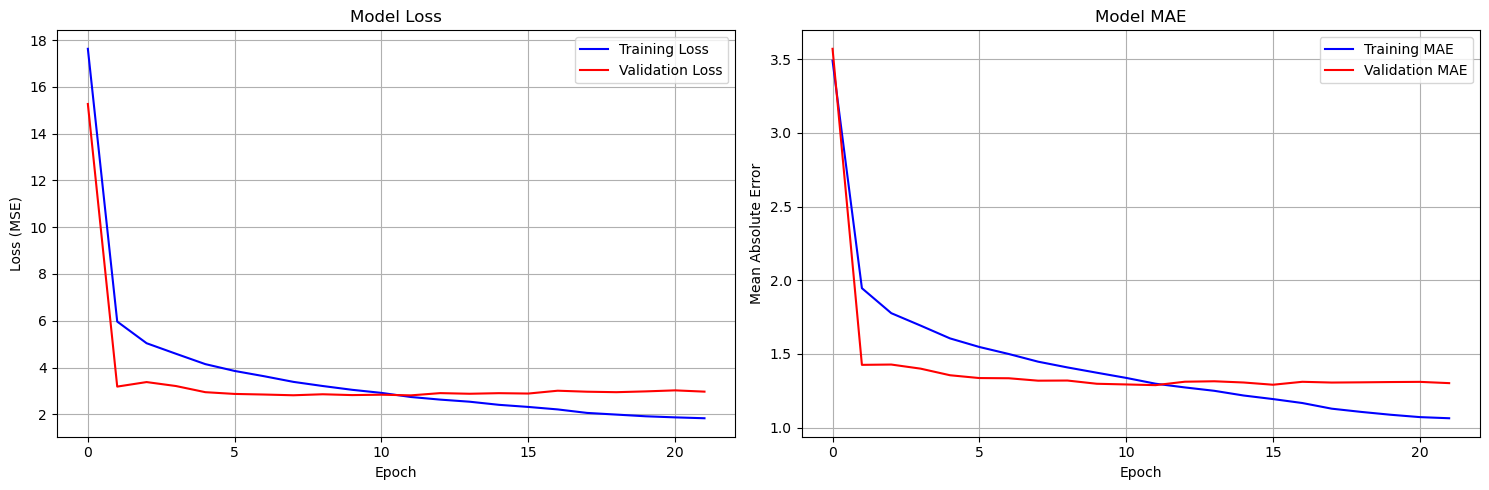

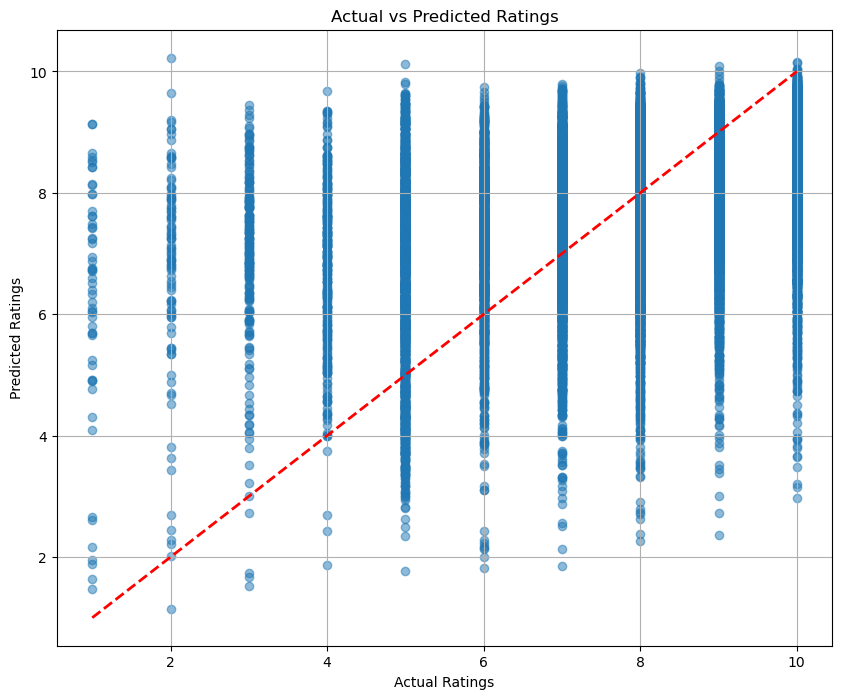

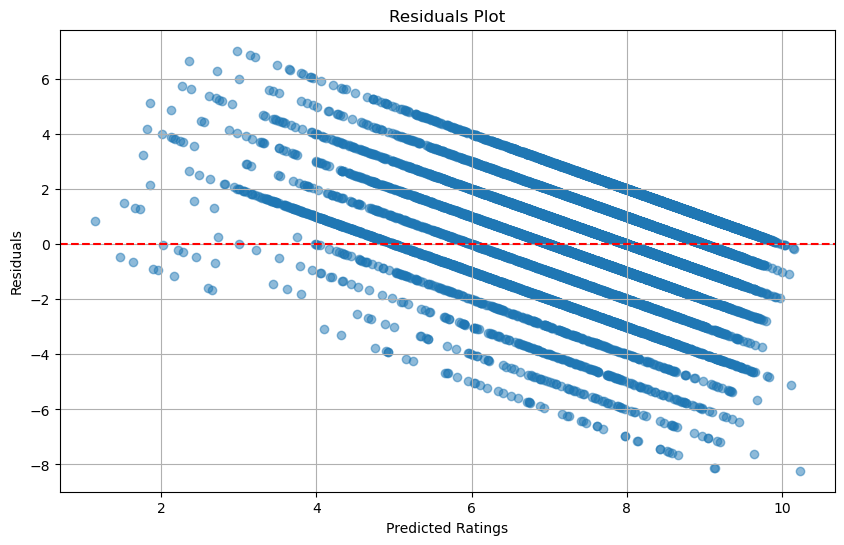

In [31]:
# Evaluate on test set
test_loss, test_mae = model.evaluate([X_user_test, X_book_test], y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {np.sqrt(test_loss):.4f}")

# Make predictions
y_pred = model.predict([X_user_test, X_book_test])

# Calculate additional metrics
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True)

# MAE plot
ax2.plot(history.history['mae'], label='Training MAE', color='blue')
ax2.plot(history.history['val_mae'], label='Validation MAE', color='red')
ax2.set_title('Model MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Prediction vs Actual scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.grid(True)
plt.show()

# Residuals plot
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

In [32]:
def get_book_recommendations(user_id, model, user_encoder, book_encoder, 
                           ratings_df, books_df, top_k=10):
    """
    Get book recommendations for a specific user
    """
    try:
        # Encode user ID
        user_encoded = user_encoder.transform([user_id])[0]
    except:
        print(f"User {user_id} not found in training data")
        return None
    
    # Get books that user hasn't rated
    user_books = set(ratings_df[ratings_df['User-ID'] == user_id]['ISBN'].values)
    all_books = set(ratings_df['ISBN'].unique())
    unrated_books = list(all_books - user_books)
    
    if len(unrated_books) == 0:
        print(f"User {user_id} has rated all available books")
        return None
    
    # Encode unrated books
    try:
        unrated_books_encoded = book_encoder.transform(unrated_books)
    except:
        # Filter out books not in encoder
        valid_books = [book for book in unrated_books if book in book_encoder.classes_]
        if len(valid_books) == 0:
            print("No valid books found for recommendations")
            return None
        unrated_books_encoded = book_encoder.transform(valid_books)
        unrated_books = valid_books
    
    # Prepare input for prediction
    user_array = np.array([user_encoded] * len(unrated_books_encoded))
    book_array = np.array(unrated_books_encoded)
    
    # Get predictions
    predictions = model.predict([user_array, book_array])
    
    # Create recommendation dataframe
    recommendations = pd.DataFrame({
        'ISBN': unrated_books,
        'predicted_rating': predictions.flatten()
    })
    
    # Sort by predicted rating
    recommendations = recommendations.sort_values('predicted_rating', ascending=False)
    
    # Merge with book information
    recommendations = recommendations.merge(books_df[['ISBN', 'Book-Title', 'Book-Author']], 
                                          on='ISBN', how='left')
    
    return recommendations.head(top_k)

# Example usage
def show_user_recommendations(user_id, ratings_filtered, books, model, 
                            user_encoder, book_encoder):
    print(f"=== RECOMMENDATIONS FOR USER {user_id} ===")
    
    # Show user's rating history
    user_history = ratings_filtered[ratings_filtered['User-ID'] == user_id].merge(
        books[['ISBN', 'Book-Title', 'Book-Author']], on='ISBN'
    ).sort_values('Book-Rating', ascending=False)
    
    print(f"\nUser's Rating History (showing top 5):")
    print(user_history[['Book-Title', 'Book-Author', 'Book-Rating']].head())
    
    # Get recommendations
    recommendations = get_book_recommendations(user_id, model, user_encoder, 
                                             book_encoder, ratings_filtered, books)
    
    if recommendations is not None:
        print(f"\nTop 10 Recommended Books:")
        for idx, row in recommendations.iterrows():
            print(f"{row.name+1:2d}. {row['Book-Title'][:50]:<50} | {row['Book-Author'][:20]:<20} | {row['predicted_rating']:.2f}")
    
    return recommendations

# Test with a random user
sample_user = ratings_filtered['User-ID'].sample(1).iloc[0]
recommendations = show_user_recommendations(sample_user, ratings_filtered, books, 
                                          model, user_encoder, book_encoder)

=== RECOMMENDATIONS FOR USER 64310 ===

User's Rating History (showing top 5):
              Book-Title       Book-Author  Book-Rating
0               Timeline  MICHAEL CRICHTON           10
8   Sunset in St. Tropez    Danielle Steel           10
17     Critical Judgment    Michael Palmer           10
15    Till We Meet Again     Judith Krantz           10
14             Flashback    Michael Palmer           10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step

Top 10 Recommended Books:
 1. Green Eggs and Ham (I Can Read It All by Myself Be | Dr. Seuss            | 10.11
 2. The Giving Tree                                    | Shel Silverstein     | 10.10
 3. Love You Forever                                   | Robert N. Munsch     | 10.04
 4. Swan Song                                          | Robert McCammon      | 10.01
 5. Cold Mountain                                      | Charles Frazier      | 10.00
 6. Low Country                                        | Anne Rivers Siddons  | 9.97


In [35]:
# Analyze embeddings
def analyze_embeddings(model, book_encoder, books_df, top_n=20):
    """
    Analyze book embeddings to find similar books
    """
    # Get book embeddings
    book_embeddings = model.layers[2].get_weights()[0]  # Book embedding layer

    # Calculate similarity matrix (cosine similarity)
    from sklearn.metrics.pairwise import cosine_similarity
    similarity_matrix = cosine_similarity(book_embeddings)

    # Find most similar books
    book_names = []
    for isbn in book_encoder.classes_:
        book_info = books_df[books_df['ISBN'] == isbn]
        if not book_info.empty:
            book_names.append(book_info['Book-Title'].iloc[0])
        else:
            book_names.append('Unknown')

    # Ensure book_names matches the number of embeddings
    n_books_embeddings = book_embeddings.shape[0]
    if len(book_names) > n_books_embeddings:
        book_names = book_names[:n_books_embeddings]
    elif len(book_names) < n_books_embeddings:
        book_names += ['Unknown'] * (n_books_embeddings - len(book_names))

    # Example: Find books similar to a random book
    random_book_idx = np.random.randint(0, len(book_names))
    similarities = similarity_matrix[random_book_idx]
    similar_indices = np.argsort(similarities)[::-1][1:top_n+1]  # Exclude self

    print(f"Books similar to: {book_names[random_book_idx]}")
    print("-" * 60)
    for i, idx in enumerate(similar_indices):
        if idx < len(book_names):
            print(f"{i+1:2d}. {book_names[idx][:50]:<50} | Similarity: {similarities[idx]:.3f}")
        else:
            print(f"{i+1:2d}. Unknown | Similarity: {similarities[idx]:.3f}")

# Run embedding analysis
analyze_embeddings(model, book_encoder, books)

# Performance summary
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"Dataset Size: {len(ratings_filtered):,} ratings")
print(f"Number of Users: {n_users:,}")
print(f"Number of Books: {n_books:,}")
print(f"Dataset Sparsity: {(1 - len(ratings_filtered)/(n_users * n_books)) * 100:.2f}%")
print(f"Test RMSE: {np.sqrt(test_loss):.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"R² Score: {r2:.4f}")

Books similar to: The Lost Boy: A Foster Child's Search for the Love of a Family
------------------------------------------------------------
 1. El Senor De Los Anillos: LA Comunidad Del Anillo ( | Similarity: 0.514
 2. Rhaeva                                             | Similarity: 0.460
 3. Robert Ludlum's the Hades Factor (Ludlum, Robert,  | Similarity: 0.459
 4. The First Eagle                                    | Similarity: 0.405
 5. The Vampire Armand : The Vampire Chronicles (Rice, | Similarity: 0.399
 6. Endurance: Shackleton's Incredible Voyage          | Similarity: 0.398
 7. Their Eyes Were Watching God: A Novel              | Similarity: 0.397
 8. The First Time                                     | Similarity: 0.390
 9. All I Really Need to Know I Learned in Kindergarte | Similarity: 0.390
10. Unknown                                            | Similarity: 0.388
11. For Better, for Worse: A Novel                     | Similarity: 0.377
12. Temptation                   